# Fitting quasi-normal modes in GW150914

We demonstrate how to use `ringdown` to fit damped sinusoids in data from the first LIGO detection, GW150914. We will make a number of pedagogical plots along the way, the actual fit should take under 2 minutes in a modern desktop computer.

_NOTE:_ this example is inteneded to demonstrate the functionality of the `ringdown` package using GW150914 as an example; it is not meant to reproduce the result from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract): we use a more general polarization model, assume different priors, and apply slightly different data conditioning; therefore, the results should not be expected to be identical Isi et al (2019).

We begin with some standard imports and global settings.

## Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", False)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

<div class="alert alert-info">

Tip

`ringdown` can run on GPUs! You can activate this through `numpyro.set_platform`. If running on a GPU, you will likely see significant performance improvements by using single precision, i.e., `config.update("jax_enable_x64", False)`; if doing so, `ringdown` will automatically attempt to scale quantities so that single precision is safe---but you should always check that this works for your data.

</div>

### Data

In this example, we will load GW150914 directly from disk. To do this, we first download it from the Gravitational-Wave Open Science Center [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/). We grab 32s of data in each IFO, sampled at 16 kHz. Ringdown supports reading both frame files and HDF5 files from GWOSC.

Verify data integrity by checking that the MD5 sums are:
```
MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853
```

In [3]:
!wget -nc https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!wget -nc https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

!openssl md5 H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

File ‘H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5’ already there; not retrieving.



/Users/maxisi/miniconda3/envs/ringdown-jax/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


File ‘L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5’ already there; not retrieving.

MD5(H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= b345645c0488287301824fe617f58dc2
MD5(L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5)= 5eb246ff21364d38471c95452f012853


<div class="alert alert-info">

Tip

Besides custom GWOSC files, `ringdown` can load any data that is readable by the `pandas` package; additionally, with the optional dependency [GWpy](http://gwpy.github.io/), `ringdown` can directly read in LIGO-Virgo-KAGRA frame files (`*.gwf`), as well as discover and load public or proprietary strain data. See docs for `rd.Fit.load_data` for further info.

</div>

## Fitting Kerr modes

The first step in a `ringdown` analysis is creating a `Fit` object. This object will contain the data and prior information, and will perform the necessary operations to run the model (including data conditioning, if requested).

Broadly speaking, `ringdown` currently allows for two types of fits based on how the frequencies ($f$) and damping rates ($\gamma$) of the damped sinusoids are parametrized:
1. _Kerr fits_ in which the frequencies and damping rates of all modes are set as a function of black hole mass ($M$) and spin ($\chi$), assuming some mode labeling (e.g., $\ell=|m|=2,\, n=0$);
2. _Free fits_ in which the frequencies and damping rates are allowed to vary freely.

An intermediate type of fit can be obtained by allowing for small deviations away from Kerr through the introduction of deviation parameters $\delta f$ and $\delta \gamma$, but we will consider this type of _beyond-Kerr_ fit a functional extension of the Kerr fits above.

We will initialize our `Fit` object by specifying which modes we would like to fit. We will first carry out a Kerr fit containing both the fundamental quadrupolar mode and an overtone.

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  The modes are elliptically polarized, so there is no need to specify both + and - `m` azimuthal numbers. (See [Isi & Farr (2021)](https://arxiv.org/abs/2107.05609).)

In [4]:
fit = rd.Fit(modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])

We will also set an analysis time, target sky location and analysis duration. We will use some reference values corresponding to an estimate of the peak of GW150914:

In [5]:
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=0.2)

<div class="alert alert-info">

Tip

By default, the target time is assumed to correspond to arrival at _geocenter_. If you want to specify time of arrival at a specific detector, you can use the `reference_ifo` argument. For example, the above is the same as
```python
fit.set_target(1126259462.423, ra=1.95, dec=-1.27, psi=0.82, duration=0.2, reference_ifo='H1')
```

Alternatively, you can also specify detector start times and antenna patterns directly by passing corresponding dictionaries to the `set_target` function.

</div>

The actual target times at each detector will be computed automatically for detectors for which data is available.

### Data preparation

One of the main features of the `Fit` object is its ability to load and manipulate data. In particular, we will usually want to:
1. filter and downsample data to reduce the number of data points analyzed;
2. estimate or load the autocovariance function (ACF) of the data
3. subselect some relevant data based on the target time and duration.

We begin by loading some data. The fit offers a variety of ways for doing this (see TIP above), but in this example we will load them directly from files on disk.

In [6]:
fit.load_data('{i}-{ifo}_GWOSC_16KHZ_R1-1126259447-32.hdf5', ifos=['H1', 'L1'], kind='GWOSC')

As a sanity-check, we can plot of the raw strain we just loaded:

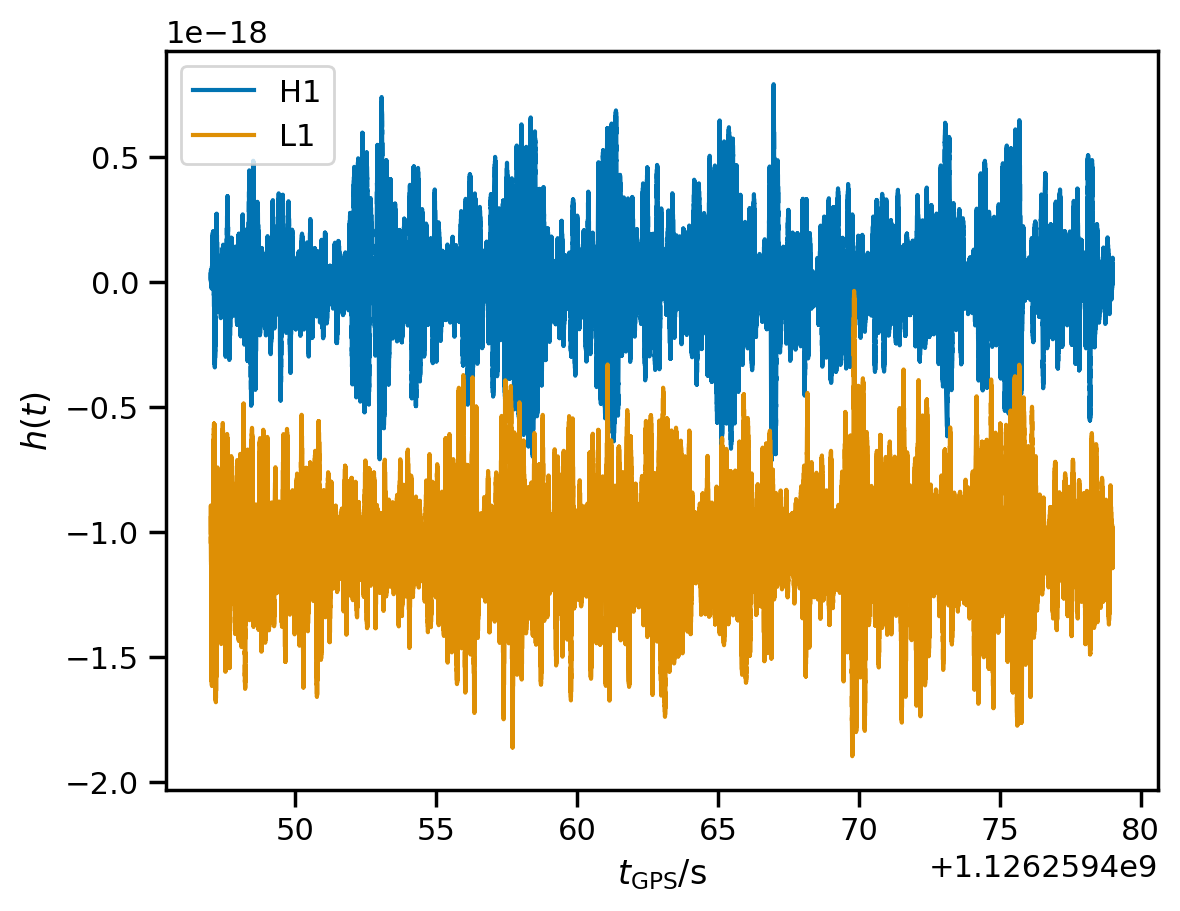

In [7]:
for ifo, data in fit.data.items():
    data[::4].plot(label=ifo)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.legend(loc='best');

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

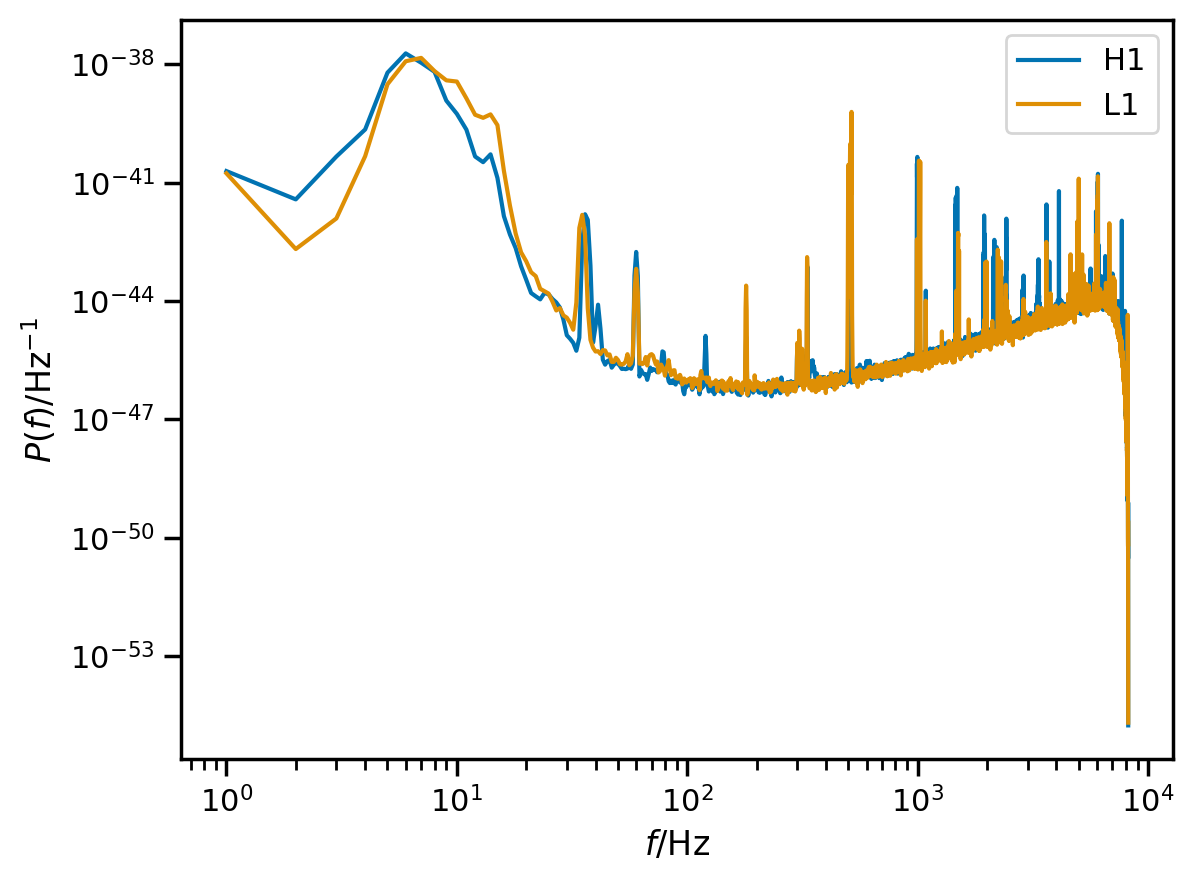

In [8]:
for ifo, data in fit.data.items():
    plt.loglog(data.get_psd().iloc[1:], label=ifo)
plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
plt.legend(loc='best');

#### Data conditioning

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a very short data segment (to eliminate low frequency content).  The `condition_data` method below accomplishes this.

When we downsample, we want to be sure to preserve a sample as close as possible to the requested target time at each detector. One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.

In [9]:
fit.condition_data(ds=8, f_min=20)

<div class="alert alert-info">

Warning

The conditioning function has a large number of options to manipulate the data in several ways. You should always make sure that the defaults make sense for your data!

</div>

We can visualize the segment of conditioned analysis data as another sanity check:

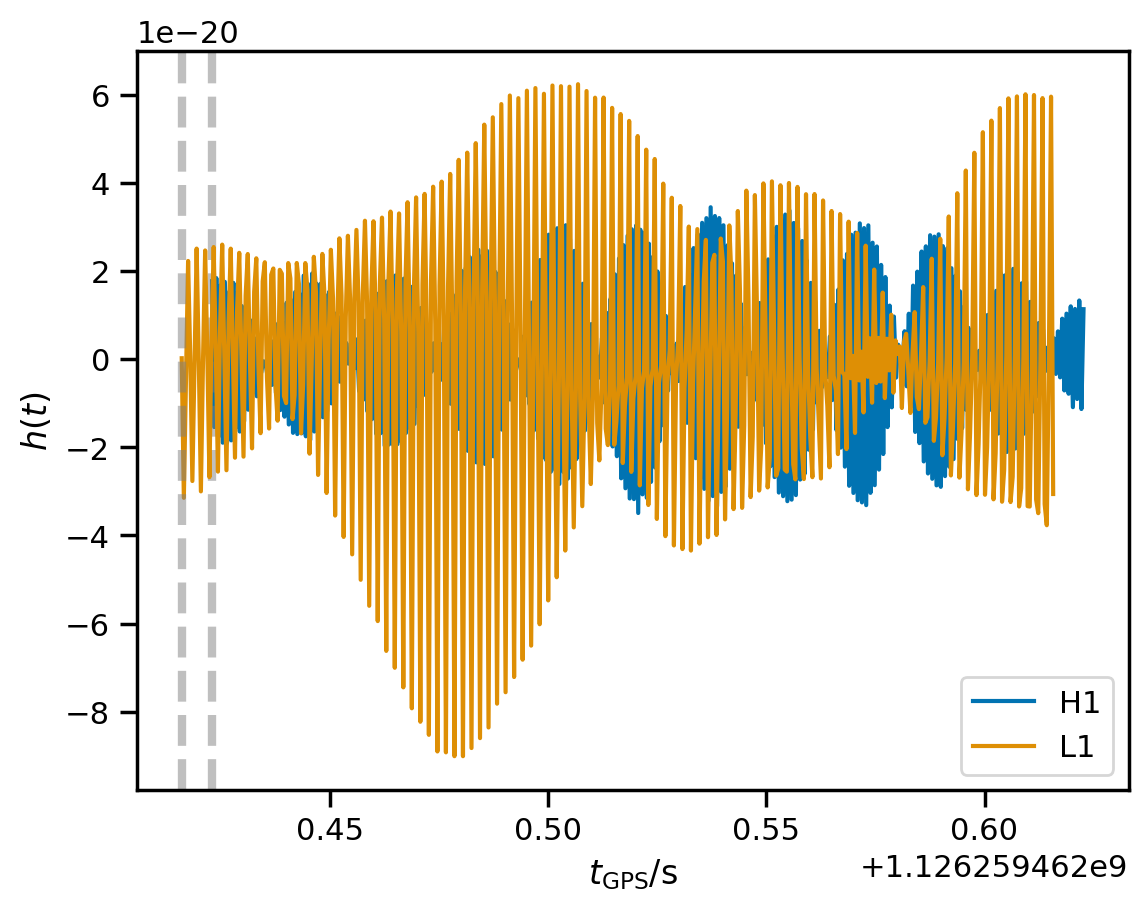

In [10]:
for i, d in fit.analysis_data.items():
    d.plot(label=i)
    plt.axvline(fit.start_times[i], ls='--', alpha=0.5, lw=3, c='gray')
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.legend(loc='best');

The wave arrived first at Livingston, then at Hanford, which is why the time segments are not exactly aligned.

#### Autocovariance function

A key ingredient in our likelihood calculation is the autocovariance function (ACF) of the noise, which is the time-domain equivalent of the power spectral density (PSD). You can load estimates of the ACF from disk, derive it from a PSD, or estimate it directly from the data. We do the latter below, with some default options.

In [11]:
fit.compute_acfs(f_min=20)

We can use the ACFs to whiten the analysis data and plot it once again.

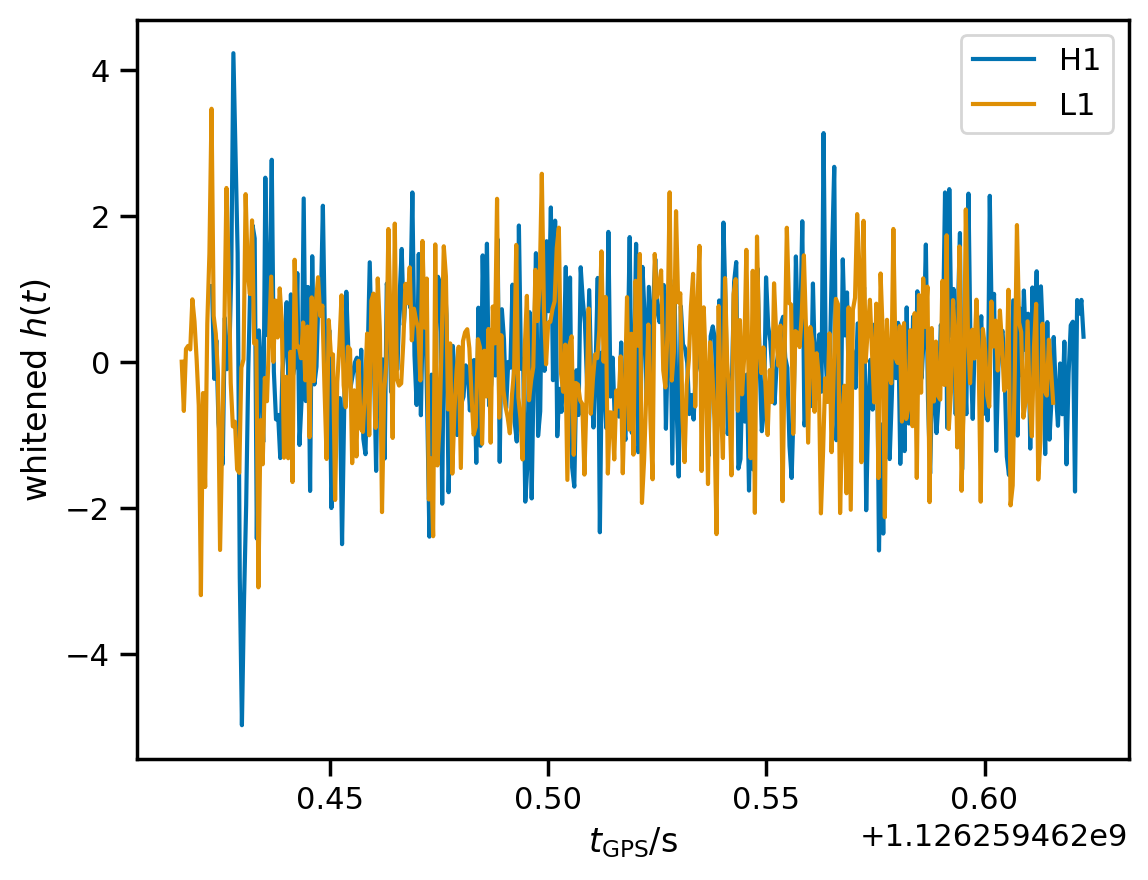

In [12]:
wd = fit.whiten(fit.analysis_data)
for i, d in wd.items():
    d.plot(label=i)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'whitened $h(t)$');
plt.legend(loc='best');

The signal is visible towards the beginning of the whitened data.

### Run fit

We are almost ready to run the fit. Before sampling over the posterior on modes, we need to set up some priors with reasonable choices. We can see all the options available by using querying the `valid_model_settings` argument.

In [13]:
print(fit.valid_model_settings)

['a_scale_max', 'marginalized', 'm_min', 'm_max', 'chi_min', 'chi_max', 'cosi_min', 'cosi_max', 'cosi', 'df_min', 'df_max', 'dg_min', 'dg_max', 'f_min', 'f_max', 'g_min', 'g_max', 'flat_amplitude_prior', 'mode_ordering']


These settings determine the prior and type of fit. For a vanilla Kerr fit with generic mode polarizations (not parametrized in terms of a source inclination), we only need to specify an amplitude scale, and a mass range.

In [14]:
fit.update_model(a_scale_max=5e-20, m_min=40.0, m_max=140.0, cosi=-1)

We are finally ready to run! This should only take a couple of minutes on a modern desktop computer using CPUs.

In [15]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
fit.result

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result of our fit is held in `fit.result`. This is just an `arviz.InferenceData` object, with some additional ringdown-specific functionality. As such we can use all tools in ArViz easily.

In [17]:
az.summary(fit.result, var_names=['a', 'm', 'chi', 'f', 'g'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[b'1,-2,2,2,0']",0.000,0.000,0.000,0.000,0.000,0.000,2275.0,2403.0,1.0
"a[b'1,-2,2,2,1']",0.000,0.000,0.000,0.000,0.000,0.000,2584.0,2122.0,1.0
m,72.383,8.273,57.068,87.285,0.205,0.151,1843.0,1071.0,1.0
chi,0.684,0.162,0.355,0.913,0.005,0.003,1768.0,919.0,1.0
"f[b'1,-2,2,2,0']",241.433,8.335,224.717,255.501,0.177,0.126,2368.0,2032.0,1.0
"f[b'1,-2,2,2,1']",236.064,9.666,216.963,252.377,0.226,0.160,2046.0,1142.0,1.0
"g[b'1,-2,2,2,0']",226.668,41.732,153.768,309.681,1.007,0.739,1862.0,1053.0,1.0
"g[b'1,-2,2,2,1']",686.032,129.184,460.948,943.514,3.141,2.316,1853.0,1045.0,1.0


We can visualize the result of the fit using a trace plot. This allows us to visualize the chains and diagnose any potential divergences.

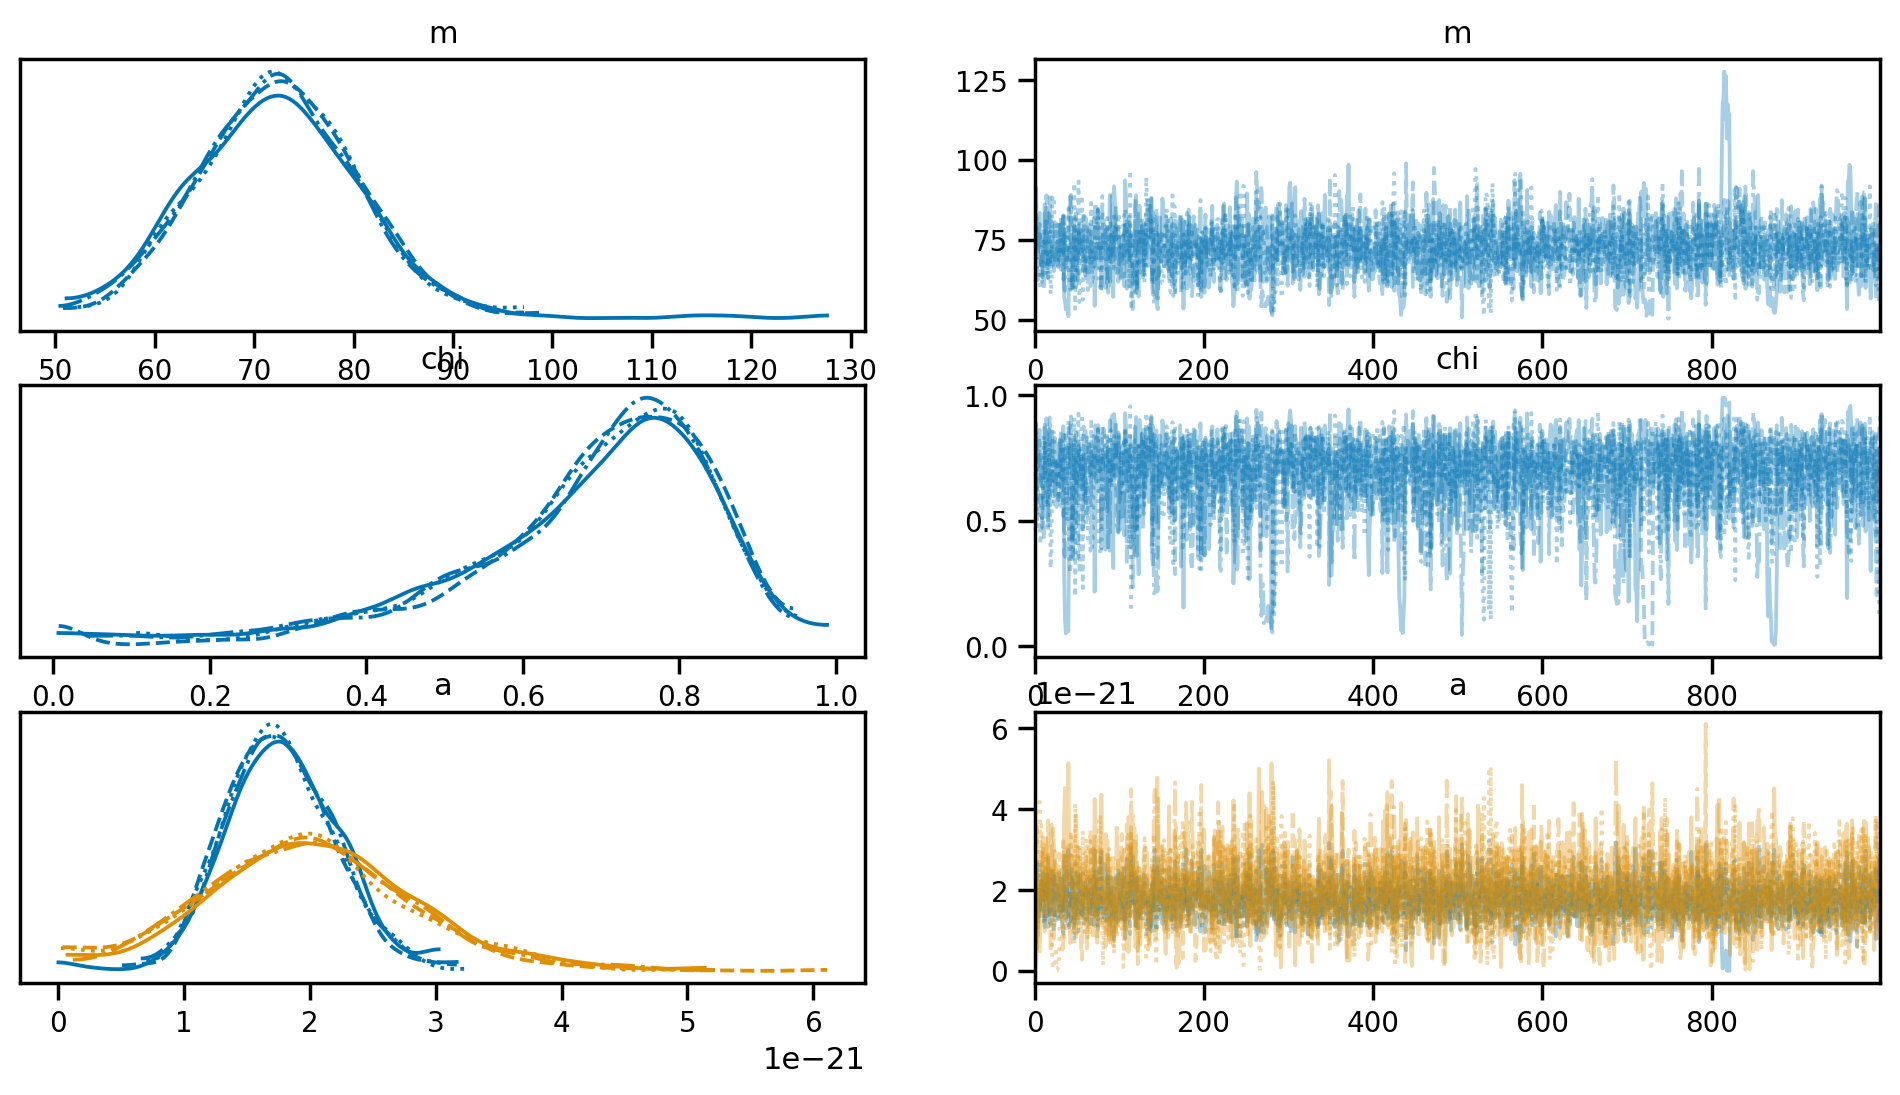

In [18]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a']);

We can access the posterior samples directly in `fit.result.posterior`. We can also obtain a Pandas `DataFrame` with all chains stacked together. This can be really convenient for plotting and other manipulations.

In [19]:
# draw 500 samples from the posterior
fit.result.get_parameter_dataframe(500, latex=True)

,$M / M_\odot$,$\chi$,$f_{220} / \mathrm{Hz}$,$f_{221} / \mathrm{Hz}$,$\gamma_{220} / \mathrm{Hz}$,$\gamma_{221} / \mathrm{Hz}$,$A_{220}$,$A_{221}$,$\phi_{220}$,$\phi_{221}$,$\epsilon_{220}$,$\epsilon_{221}$
976,86.883652,0.891219,246.025070,244.359467,154.891510,466.504120,1.214850e-21,1.363235e-21,1.311926,-0.855615,-1.0,-1.0
109,73.052971,0.638229,224.545822,218.729507,230.102982,696.556519,1.136069e-21,5.149037e-22,0.292675,-1.056752,-1.0,-1.0
2283,75.433540,0.732346,234.703110,230.269043,213.766525,645.490356,1.385992e-21,1.366664e-21,0.964994,-1.188032,-1.0,-1.0
2012,84.375168,0.871328,245.633041,243.592606,166.004974,500.033997,1.165810e-21,1.391032e-21,1.250563,-1.111712,-1.0,-1.0
1447,75.671066,0.746724,237.083984,232.861221,211.257004,637.691589,1.780924e-21,8.709574e-22,0.663118,-2.011150,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
942,78.266647,0.735815,226.920609,222.692719,205.613174,620.817932,1.519224e-21,1.478490e-21,0.571167,-2.033196,-1.0,-1.0
2896,62.648323,0.525798,243.055023,234.751434,276.251923,838.935303,2.422252e-21,3.213031e-21,0.824368,-1.980818,-1.0,-1.0
2284,78.225357,0.831742,251.200531,248.348557,189.751221,571.815857,1.733343e-21,2.098505e-21,1.196790,-1.409812,-1.0,-1.0
1092,77.829216,0.814332,247.279617,244.142715,194.462753,586.175781,1.386842e-21,1.487938e-21,1.186367,-1.103986,-1.0,-1.0


### Plot results

We can make some quick plots of the results using arviz and seaborn. Below we demonstrate a few possible ways of doing this.

#### Remnant mass and spin

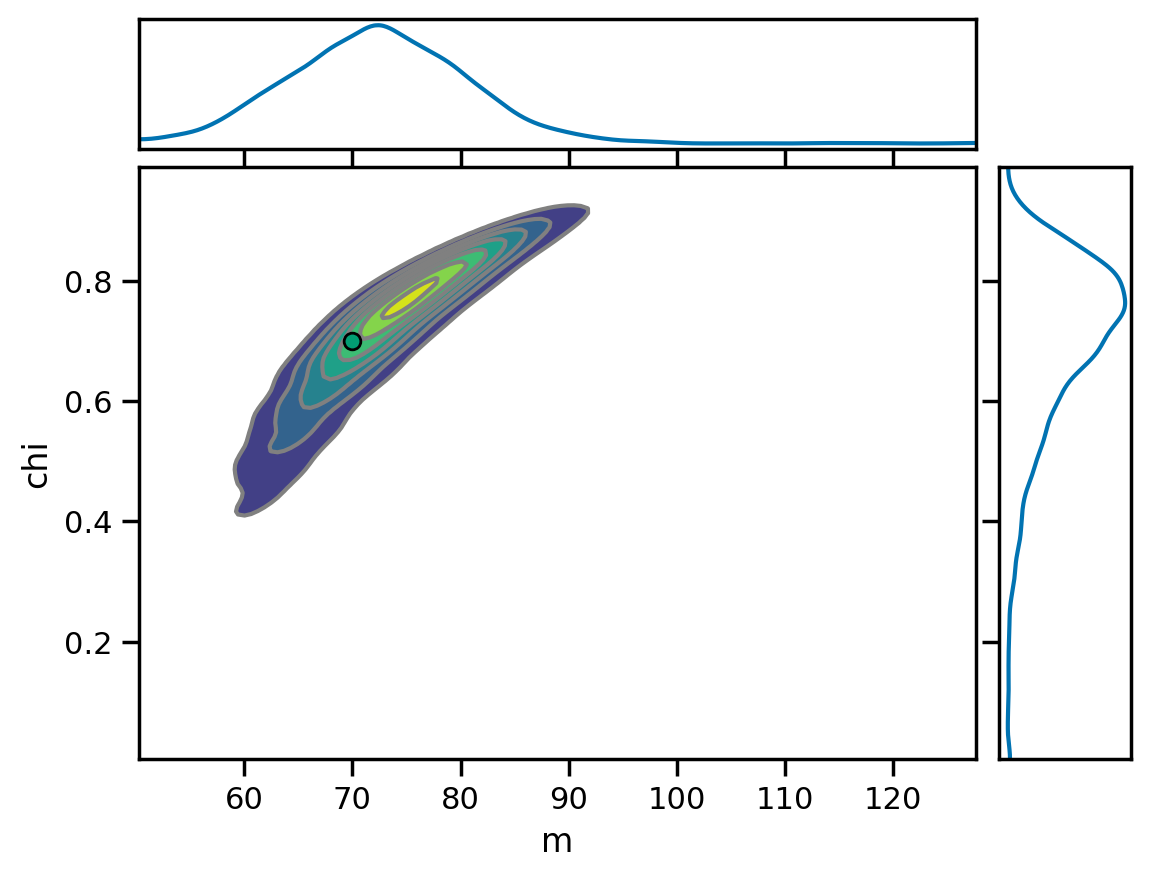

In [20]:
az.plot_pair(fit.result, var_names=['m', 'chi'], marginals=True,
             kind='kde', reference_values={'m': 70, 'chi': 0.7});

#### Mode amplitudes

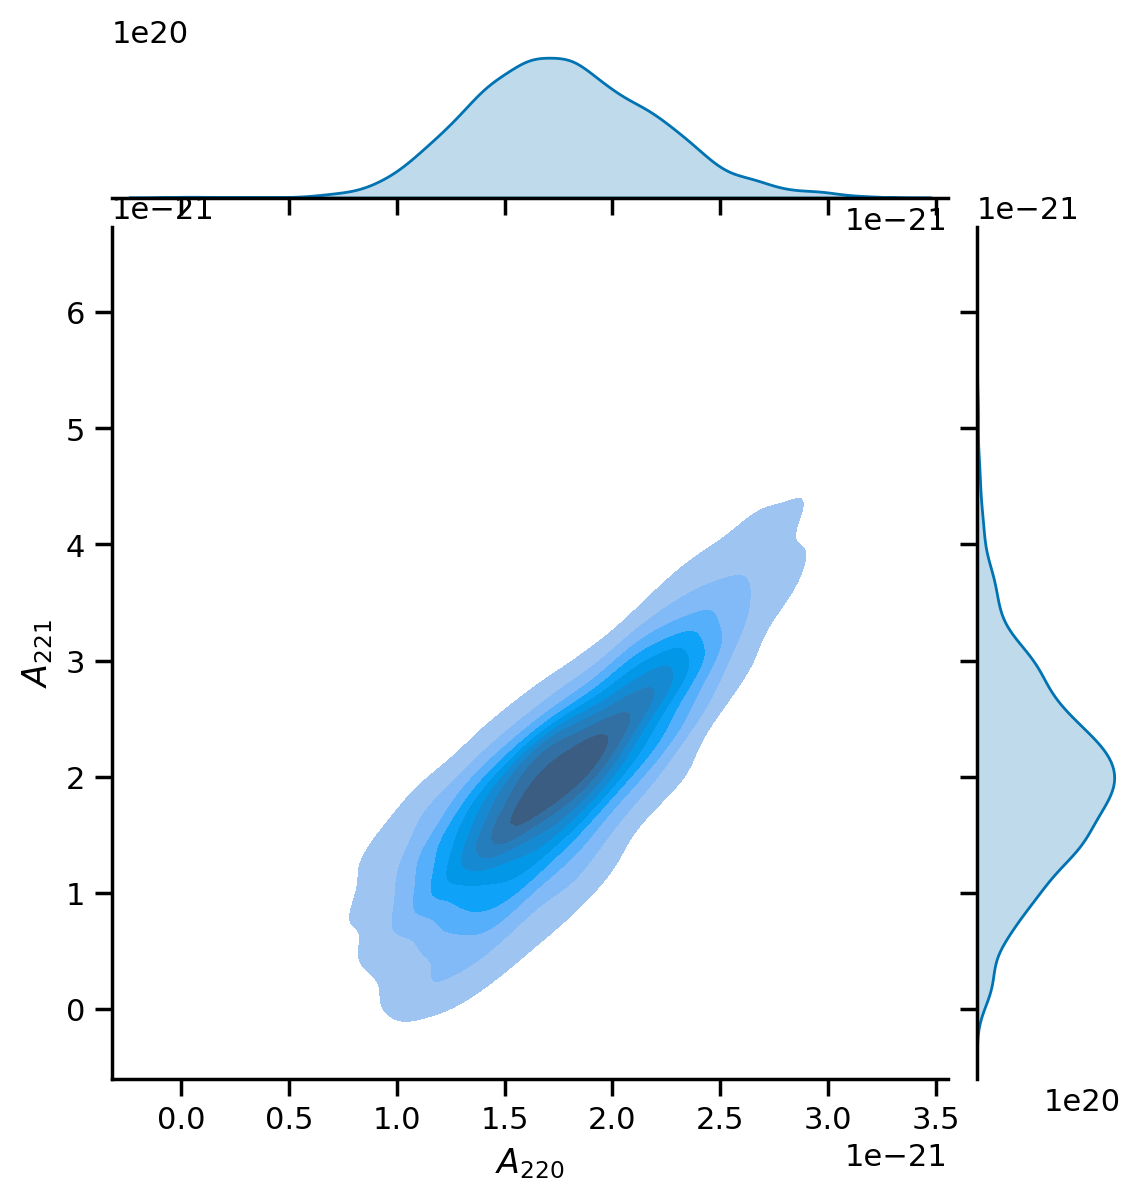

In [21]:
df = fit.result.get_parameter_dataframe()
g = sns.jointplot(x=df['a_220'], y=df['a_221'], kind='kde', fill=True);
g.ax_joint.set_xlabel('$A_{220}$');
g.ax_joint.set_ylabel('$A_{221}$');

#### Mode frequencies

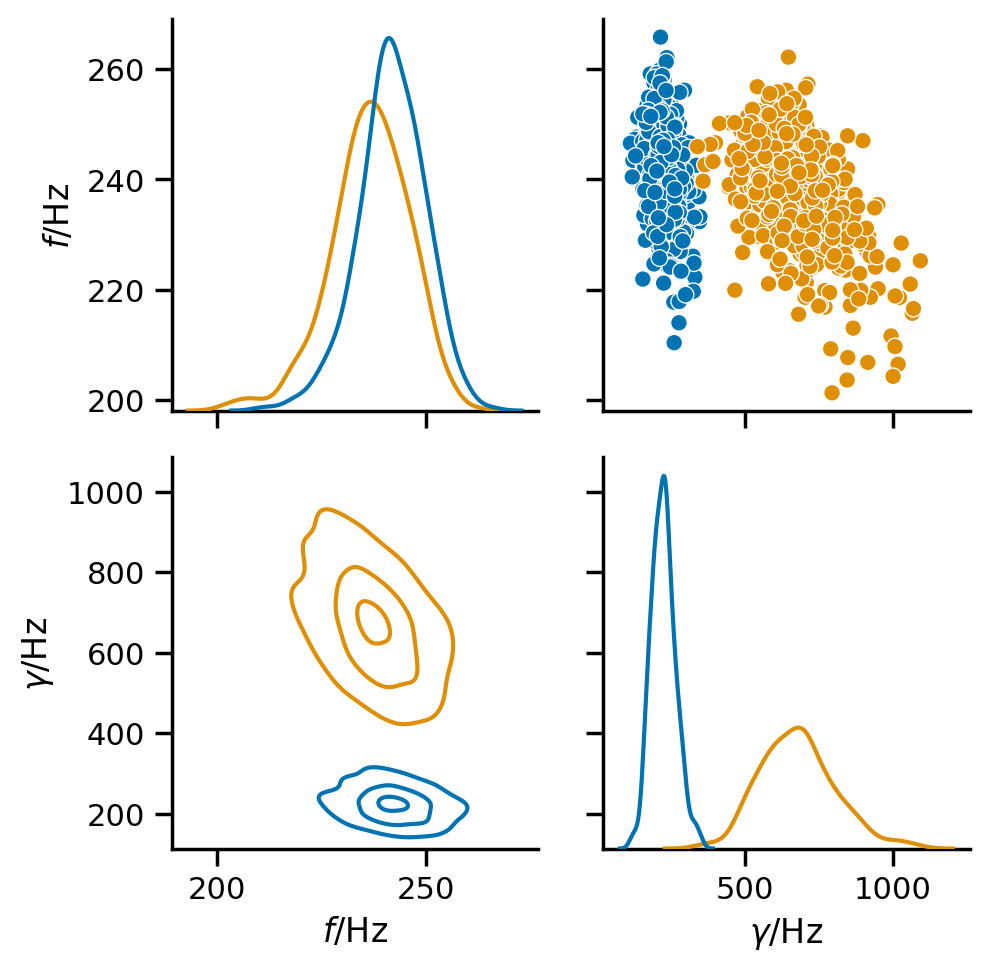

In [22]:
df = fit.result.get_mode_parameter_dataframe(500, latex=True)
key_map = fit.result.get_parameter_key_map(modes=False)

pg = sns.PairGrid(df, vars=[key_map[k] for k in ['f', 'g']],
                  diag_sharey=False, hue='mode')
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.utils.kdeplot, levels=[0.9, 0.5, 0.1]);

#### Waveform reconstructions

Plot 90% credible interval for the reconstructions at each detector.

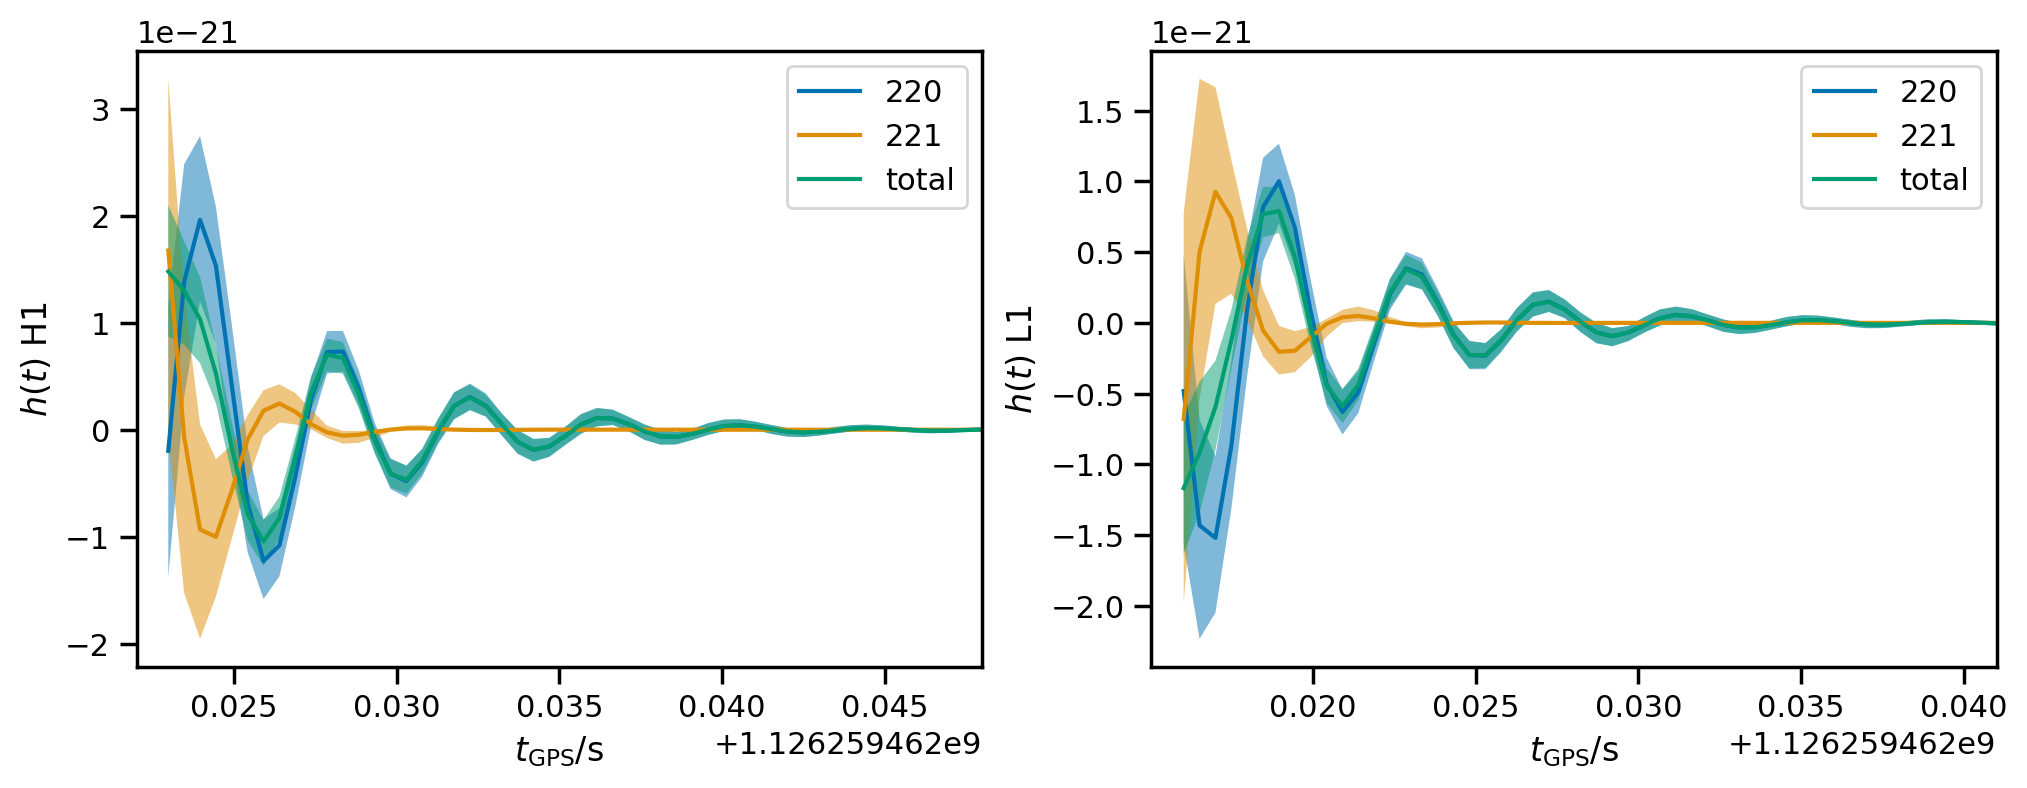

In [23]:
fig, axs = plt.subplots(1, len(fit.ifos), figsize=(12, 4))
axs = np.atleast_1d(axs)
for mode in fit.result.modes:
    hdet_mode_cls = [fit.result.get_strain_quantile(q, mode=mode) for q in [0.5, 0.05, 0.95]]
    for i, ax in zip(fit.ifos, axs):
        m, l, h = [hcl[i] for hcl in hdet_mode_cls]
        ax.plot(m, label=mode.get_label())
        ax.fill_between(m.index, l, h, alpha=0.5)
    
hdet_cls = [fit.result.get_strain_quantile(q) for q in [0.5, 0.05, 0.95]]    
for i, ax in zip(fit.ifos, axs):
    m, l, h = [hcl[i] for hcl in hdet_cls]
        
    ax.plot(m, label='total')
    ax.fill_between(m.index, l, h, alpha=0.5)
    
    ax.set_xlim(fit.start_times[i]- 0.001,
                fit.start_times[i] + 0.025)
    ax.set_xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$')
    ax.set_ylabel(f'$h(t)$ {i}');
    ax.legend();

#### Signal to noise ratio

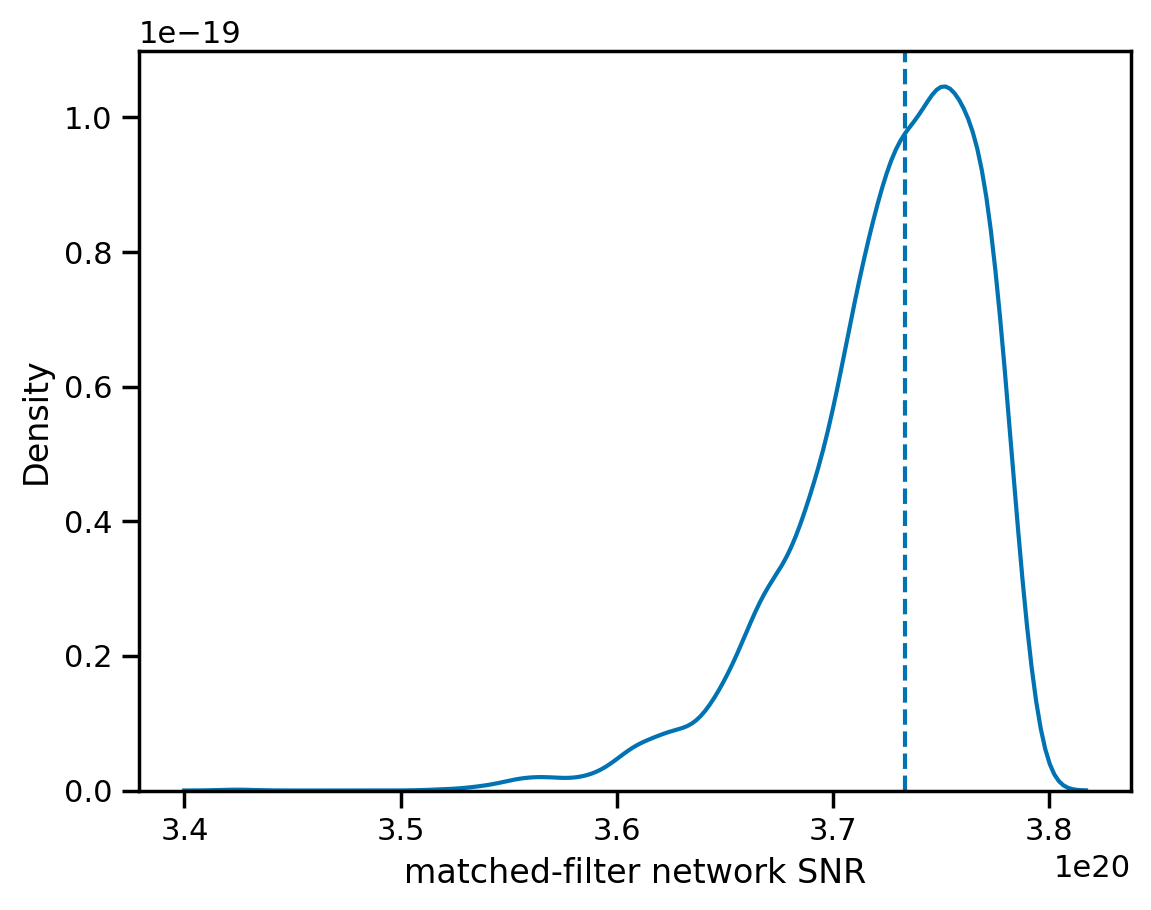

In [24]:
snrs = fit.result.compute_posterior_snrs(optimal=False)
sns.kdeplot(snrs);
plt.axvline(np.median(snrs), ls='--')
plt.xlabel('matched-filter network SNR');